In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Load datasets
filepath_train_test = './train_test_data/dataset.csv'
filepath_validation = "./validation_data/dataset.csv"

df = pd.read_csv(filepath_train_test)
df_validation = pd.read_csv("./validation_data/dataset.csv")


In [101]:
# Aligning the datasets

# Find the difference in columns
unique_to_df1 = df.columns.difference(df_validation.columns)
unique_to_df2 = df_validation.columns.difference(df.columns)

# Drop the unique columns from each DataFrame
df = df.drop(columns=unique_to_df1)
df_validation = df_validation.drop(columns=unique_to_df2)
df_validation = df_validation[df.columns]

df.drop('_time', axis=1, inplace=True)
df_validation.drop('_time', axis=1, inplace=True)

In [163]:
# Prepare datasets for modeling and prediction

# Get X and y
y = df['5xx_lag_agg']
X = df.drop('5xx_lag_agg', axis=1)

# Get X and y for validation set
y_val = df_validation['5xx_lag_agg']
X_val = df_validation.drop('5xx_lag_agg', axis=1)

# Perform the train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# # Use SMOTE for oversampling minority classes
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [164]:
# Train random forest using all available metrics

# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the model
rf.fit(X_train, y_train)

test_set = [X_test, y_test]
val_set = [X_val, y_val]

for dataset, name in zip([test_set, val_set], ["test_set", "val_set"]):
    y_pred = rf.predict(dataset[0])

    print("\nDataset: ", name)
    print("\nAccuracy:", accuracy_score(dataset[1], y_pred))
    print(classification_report(dataset[1], y_pred))
    f1_macro = f1_score(dataset[1], y_pred, average='macro')
    print("Macro-Averaged F1-Score:", f1_macro)
    y_prob = rf.predict_proba(dataset[0])
    roc_auc = roc_auc_score(dataset[1], y_prob, multi_class='ovr')
    print("\nAUC-ROC:", roc_auc)
    print("\nConfusion Matrix:")
    print(confusion_matrix(dataset[1], y_pred))



Dataset:  test_set

Accuracy: 0.9805068226120858
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       262
           1       0.95      0.96      0.96        82
           2       0.96      0.96      0.96        71
           3       0.99      0.98      0.98        98

    accuracy                           0.98       513
   macro avg       0.97      0.97      0.97       513
weighted avg       0.98      0.98      0.98       513

Macro-Averaged F1-Score: 0.9730760083195306

AUC-ROC: 0.9990510987894476

Confusion Matrix:
[[260   2   0   0]
 [  2  79   1   0]
 [  0   2  68   1]
 [  0   0   2  96]]

Dataset:  val_set

Accuracy: 0.9138134592680047
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1584
           1       0.82      0.86      0.84       454
           2       0.44      0.34      0.38       133
           3       0.90      0.93      0.91       370

    accuracy             

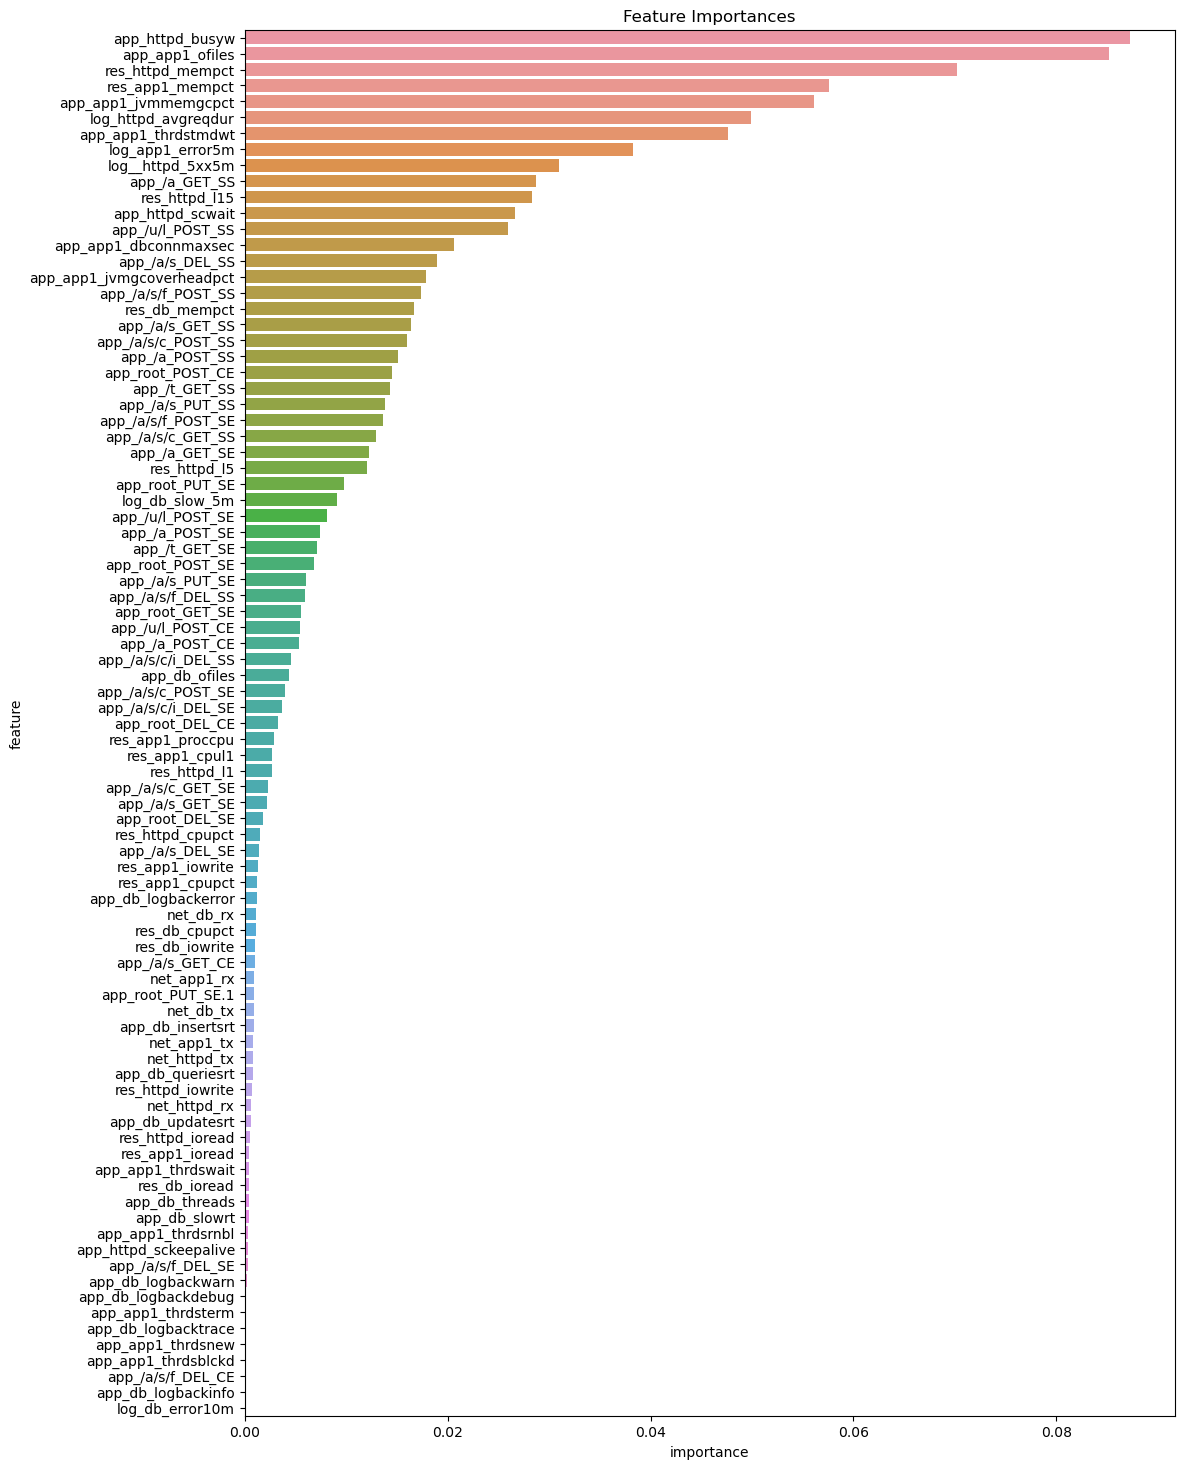

In [167]:
feature_importances = rf.feature_importances_

feature_names = X_val.columns
importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

importances = importances.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 18))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Feature Importances')
plt.show()

In [168]:
# Get top x features to reduce dimensionality
feature_importances = pd.Series(feature_importances, index=X_val.columns).sort_values(ascending=False)
top_x = 16

In [169]:
# Train a new model with the top X features
top_x_features = feature_importances.head(top_x).index.tolist()
X_train_top_x = X_train[top_x_features]
X_test_top_x = X_test[top_x_features]
X_val_top_x = X_val[top_x_features]

test_set = [X_test_top_x, y_test]
val_set = [X_val_top_x, y_val]

rf.fit(X_train_top_x, y_train)

for dataset, name in zip([test_set, val_set], ["test_set", "val_set"]):
    y_pred = rf.predict(dataset[0])

    print("\nDataset: ", name)
    print("\nAccuracy:", accuracy_score(dataset[1], y_pred))
    print(classification_report(dataset[1], y_pred))
    f1_macro = f1_score(dataset[1], y_pred, average='macro')
    print("Macro-Averaged F1-Score:", f1_macro)
    y_prob = rf.predict_proba(dataset[0])
    roc_auc = roc_auc_score(dataset[1], y_prob, multi_class='ovr')
    print("\nAUC-ROC:", roc_auc)
    print("\nConfusion Matrix:")
    print(confusion_matrix(dataset[1], y_pred))


Dataset:  test_set

Accuracy: 0.9805068226120858
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       262
           1       0.97      0.94      0.96        82
           2       0.96      0.99      0.97        71
           3       0.99      0.98      0.98        98

    accuracy                           0.98       513
   macro avg       0.98      0.97      0.98       513
weighted avg       0.98      0.98      0.98       513

Macro-Averaged F1-Score: 0.9754881254653944

AUC-ROC: 0.9992488081982775

Confusion Matrix:
[[260   2   0   0]
 [  4  77   1   0]
 [  0   0  70   1]
 [  0   0   2  96]]

Dataset:  val_set

Accuracy: 0.8941361668634396
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1584
           1       0.73      0.86      0.79       454
           2       0.48      0.62      0.54       133
           3       0.98      0.85      0.91       370

    accuracy             

In [153]:
# Grid search cross validation
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 60, 70, 80, 90, 100, 200],
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 4, 6, 10],
    'min_samples_leaf': [1, 2, 4, 5, 7],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}


# Initialize the model
rf = RandomForestClassifier(random_state=0)

# Initialize the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_top_x, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 5600 candidates, totalling 16800 fits
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, criterion

In [162]:
# Use the best parameters from the grid search
# {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80}
best_params = grid_search.best_params_
rf = RandomForestClassifier(**best_params, random_state=0)

rf.fit(X_train_top_x, y_train)

# Evaluate the model
for dataset, name in zip([test_set, val_set], ["test_set", "val_set"]):
    y_pred = rf.predict(dataset[0])

    print("\nDataset: ", name)
    print("\nAccuracy:", accuracy_score(dataset[1], y_pred))
    print(classification_report(dataset[1], y_pred))
    f1_macro = f1_score(dataset[1], y_pred, average='macro')
    print("Macro-Averaged F1-Score:", f1_macro)
    y_prob = rf.predict_proba(dataset[0])
    roc_auc = roc_auc_score(dataset[1], y_prob, multi_class='ovr')
    print("\nAUC-ROC:", roc_auc)
    print("\nConfusion Matrix:")
    print(confusion_matrix(dataset[1], y_pred))



Dataset:  test_set

Accuracy: 0.9785575048732943
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       262
           1       0.97      0.94      0.96        82
           2       0.96      0.97      0.97        71
           3       0.98      0.98      0.98        98

    accuracy                           0.98       513
   macro avg       0.97      0.97      0.97       513
weighted avg       0.98      0.98      0.98       513

Macro-Averaged F1-Score: 0.9724354241984074

AUC-ROC: 0.9988269367639053

Confusion Matrix:
[[260   2   0   0]
 [  4  77   1   0]
 [  0   0  69   2]
 [  0   0   2  96]]

Dataset:  val_set

Accuracy: 0.9016135379771744
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1584
           1       0.75      0.89      0.81       454
           2       0.45      0.55      0.49       133
           3       0.99      0.86      0.92       370

    accuracy             

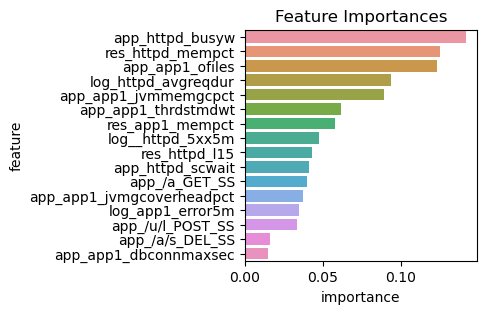

In [171]:
feature_importances = rf.feature_importances_

feature_names = X_val_top_x.columns
importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

importances = importances.sort_values('importance', ascending=False)

plt.figure(figsize=(3, 3))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Feature Importances')
plt.show()
